In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/Siamese/Speaker/Time'

/content/drive/My Drive/Siamese/Speaker/Time


In [ ]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../../Data')
sys.path.insert(0, '../../Encoder/Time')
sys.path.insert(0, '../../Encoder/Freq')
sys.path.insert(0, '../../Encoder')
sys.path.insert(0, '../../Conference')
sys.path.insert(0, '../../Place')

In [ ]:
!pip install torchvision==0.5.0
!pip install torchaudio==0.4.0

     |████████████████████████████████| 4.0MB 3.5MB/s 
     |████████████████████████████████| 753.4MB 22kB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
     |████████████████████████████████| 3.1MB 3.3MB/s 


In [ ]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [ ]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
EPOCH_NUM = 10
SPEAKERS_NUM = 20

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [ ]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from torchvision.transforms import Compose
from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

testset = IdentificationDataset(DATASET_PATH, 
                                SPEAKERS_NUM,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght test loader ", len(testsetloader))


sample lenght  3
lenght test loader  2134


In [ ]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = Conference(DEVICE,
                 avg=False,
                 time=True)

net.load_encoder(size=2)
net.to(DEVICE)

cuda
Encoder loaded


Conference(
  (encoder): Time(
    (block0): Conv1DBlock(
      (conv): Conv1d(1, 32, kernel_size=(9,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=9, stride=8, padding=0, dilation=1, ceil_mode=False)
    )
    (block1): Conv1DBlock(
      (conv): Conv1d(32, 256, kernel_size=(9,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=9, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv1DBlock(
      (conv): Conv1d(256, 256, kernel_size=(9,), stride=(2,))
      (acti): ReLU()
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool1d(kernel_size=9, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv1DBlock(
      (conv1): Conv1d(256, 64, kernel_size=(

In [ ]:
with torch.no_grad():
  # test
  net.eval()
  # Store the speakers
  speakers_list = testset.get_speakers_list(20)
  net.initspeakers(speakers_list)  
  net.initplaces(speakers_list)

In [ ]:
import numpy as np

dict_error = {}
dict_nb = {}

with torch.no_grad():
  best_accuracy = 0
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []

  for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    topk_accuracy = 0
    min_accuracy = 0
    nb_test = 0
    if epoch_num == EPOCH_NUM-1:
      print("activate stats")
      net.activatestats()

    for speaker in speakers_list:
      id = speaker[0]
      dict_error[id] = 0
      dict_nb[id] = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      mean_label, topk_label, min_label = net(sample, gold_label)
      nb_test += 1
      gold_label = gold_label.item()
      dict_nb[gold_label] += 1

      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == topk_label:
        topk_accuracy += 1
      else:
        dict_error[gold_label] += 1
      if gold_label == min_label:
        min_accuracy += 1

    mean_accuracy /= nb_test
    topk_accuracy /= nb_test
    min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    topk_accuracies.append(topk_accuracy)
    min_accuracies.append(min_accuracy)
    print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
          " min ", min_accuracy)
    add = 0
    nb = 0
    for id in dict_error:
      add += dict_error[id]
      nb += dict_nb[id]
      dict_error[id] =  100 * dict_error[id]//dict_nb[id] 
    print("Error ", add/nb)
    print(dict_error)

  net.store_speakers(20, 3)
  net.dumpstats()

*** Epoch  0  ***


2134it [02:40, 13.28it/s]

accuracy mean  0.3917525773195876 topk 0.53514526710403  min  0.5276476101218369
Error  0.46485473289597
{270: 9, 272: 74, 273: 45, 274: 92, 275: 40, 276: 28, 277: 46, 278: 13, 271: 47, 279: 98, 280: 43, 281: 45, 282: 58, 283: 47, 285: 100, 284: 30, 286: 22, 287: 95, 288: 62, 289: 100}
*** Epoch  1  ***



2134it [00:56, 37.73it/s]

accuracy mean  0.4620431115276476 topk 0.5773195876288659  min  0.5529522024367385
Error  0.422680412371134
{270: 13, 272: 68, 273: 47, 274: 87, 275: 27, 276: 41, 277: 43, 278: 22, 271: 32, 279: 80, 280: 40, 281: 47, 282: 34, 283: 38, 285: 84, 284: 22, 286: 23, 287: 81, 288: 52, 289: 66}
*** Epoch  2  ***



2134it [00:58, 36.66it/s]


accuracy mean  0.4873477038425492 topk 0.60543580131209  min  0.5684161199625117
Error  0.39456419868791004
{270: 17, 272: 64, 273: 56, 274: 79, 275: 17, 276: 45, 277: 37, 278: 26, 271: 27, 279: 57, 280: 40, 281: 48, 282: 33, 283: 37, 285: 58, 284: 17, 286: 26, 287: 60, 288: 41, 289: 37}
*** Epoch  3  ***


2134it [00:56, 37.45it/s]

accuracy mean  0.5238987816307404 topk 0.6059044048734771  min  0.5712277413308341
Error  0.394095595126523
{270: 22, 272: 64, 273: 60, 274: 70, 275: 17, 276: 45, 277: 37, 278: 26, 271: 28, 279: 50, 280: 38, 281: 47, 282: 35, 283: 35, 285: 47, 284: 16, 286: 34, 287: 52, 288: 39, 289: 35}
*** Epoch  4  ***



2134it [00:54, 39.48it/s]

accuracy mean  0.5295220243673852 topk 0.5965323336457357  min  0.584817244611059
Error  0.4034676663542643
{270: 22, 272: 58, 273: 62, 274: 57, 275: 21, 276: 51, 277: 35, 278: 28, 271: 27, 279: 46, 280: 43, 281: 45, 282: 40, 283: 38, 285: 48, 284: 18, 286: 38, 287: 43, 288: 41, 289: 32}
*** Epoch  5  ***



2134it [00:51, 41.80it/s]

accuracy mean  0.5318650421743205 topk 0.5941893158388004  min  0.584348641049672
Error  0.40581068416119964
{270: 21, 272: 54, 273: 62, 274: 53, 275: 22, 276: 55, 277: 38, 278: 27, 271: 26, 279: 46, 280: 40, 281: 52, 282: 38, 283: 39, 285: 44, 284: 18, 286: 40, 287: 37, 288: 43, 289: 34}
*** Epoch  6  ***



2134it [00:50, 42.19it/s]

accuracy mean  0.5379568884723523 topk 0.5932521087160263  min  0.5834114339268979
Error  0.40674789128397376
{270: 24, 272: 48, 273: 61, 274: 48, 275: 25, 276: 55, 277: 38, 278: 24, 271: 28, 279: 44, 280: 41, 281: 54, 282: 40, 283: 42, 285: 47, 284: 17, 286: 40, 287: 31, 288: 41, 289: 32}
*** Epoch  7  ***



2134it [00:50, 41.87it/s]

accuracy mean  0.5318650421743205 topk 0.5913776944704779  min  0.5768509840674789
Error  0.408622305529522
{270: 22, 272: 52, 273: 58, 274: 48, 275: 33, 276: 58, 277: 37, 278: 26, 271: 28, 279: 42, 280: 41, 281: 48, 282: 38, 283: 41, 285: 47, 284: 20, 286: 40, 287: 33, 288: 43, 289: 36}
*** Epoch  8  ***



2134it [00:50, 42.35it/s]

accuracy mean  0.5332708528584817 topk 0.5890346766635426  min  0.5754451733833177
Error  0.41096532333645736
{270: 20, 272: 54, 273: 59, 274: 46, 275: 33, 276: 62, 277: 35, 278: 25, 271: 28, 279: 46, 280: 38, 281: 50, 282: 36, 283: 42, 285: 46, 284: 18, 286: 41, 287: 33, 288: 43, 289: 35}
*** Epoch  9  ***
activate stats



2134it [00:54, 38.85it/s]


accuracy mean  0.5356138706654171 topk 0.5909090909090909  min  0.5768509840674789
Error  0.4090909090909091
{270: 19, 272: 52, 273: 60, 274: 46, 275: 33, 276: 61, 277: 37, 278: 21, 271: 30, 279: 46, 280: 38, 281: 54, 282: 38, 283: 43, 285: 45, 284: 17, 286: 38, 287: 31, 288: 41, 289: 39}
Stats for  270  :  tensor([5.0386, 5.2527, 5.4753, 5.7979, 5.9269, 6.0417, 6.2106, 6.3321, 6.4515,
        6.6187, 6.7134, 6.8125, 6.8992, 7.0034, 7.0905, 7.1754, 7.2702, 7.3808,
        7.5005, 7.6302], device='cuda:0')
Stats for  272  :  tensor([3.6368, 4.0395, 4.3112, 4.5381, 4.7996, 5.1332, 5.3058, 5.4815, 5.6789,
        5.9274, 6.1998, 6.5047, 6.6362, 6.7875, 6.9253, 7.0884, 7.2878, 7.4774,
        7.7286, 7.8933], device='cuda:0')
Stats for  273  :  tensor([4.9642, 5.4223, 5.6316, 5.8292, 5.9442, 6.0421, 6.1434, 6.2412, 6.3347,
        6.4188, 6.4937, 6.5662, 6.6375, 6.7091, 6.7850, 6.8562, 6.9331, 7.0262,
        7.1375, 7.2951], device='cuda:0')
Stats for  274  :  tensor([4.4010, 4.8937, 5.15

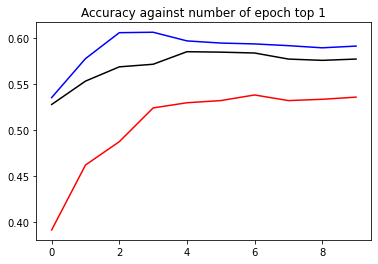

In [ ]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], mean_accuracies , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], topk_accuracies , label='test 1', color='blue')
plt.plot([i for i in range(EPOCH_NUM)], min_accuracies , label='test 1', color='black')


In [ ]:
print("maximum of min", round(np.max(min_accuracies), 3))
print("maximum of topk", round(np.max(topk_accuracies), 3))
print("maximum of mean", round(np.max(mean_accuracies), 3))


maximum of min 0.585
maximum of topk 0.606
maximum of mean 0.538
